In [2]:
%matplotlib inline
from config_calc import *
import grid_tools

from collections import OrderedDict

import cesm_orcas_sci as cesm
import cam
import metpy.calc as mcalc

import matplotlib.pyplot as plt

### read model data set

In [3]:
%%time
case = 'bgeos5.B20TRC5CN.f09_g16.BPRD_orcas_sci.004a'

tracer_def = cesm.trace_gas_tracers(case)
tracer_3d = [k for k in tracer_def]
varlist = ['Z3','Q','PS','PBLH','T','U','V','U10','PSL','OMEGA']+tracer_3d

dsa = cesm.open_casedata(case,'atm','cam.h0',varlist)
dsa.time

CPU times: user 10min 40s, sys: 31.8 s, total: 11min 11s
Wall time: 11min 35s


### read flight data
Find the right day in the model data and subset; store a list of obs datasets 

In [4]:
RF = []
MDL = []
co2varname = []
flight_file = ['HIPPO_all_missions_merge_10s_20121129_CO2X.nc','ATom123_2018-01-20_CO2_NOAA.nc']
for f in flight_file:
    rf = xr.open_dataset(os.path.join('data',f))
    
    #-- handle some peculiarities
    co2var = [v for v in rf.variables if 'CO2' in v][0]
    co2 = rf[co2var]
    rf = rf.drop(co2var).rename({co2var:'sample'})
    co2varname.append(co2var)
    rf['sample'] = xr.DataArray(np.arange(0,len(rf.sample)),dims='sample')
    rf['time'] = xr.DataArray([datetime(d[0],d[1],d[2],d[3],d[4],d[5]) for d in rf.Datetime.values],dims='sample')
    rf[co2var] = xr.DataArray(co2.values,dims='sample')
    RF.append(rf)
    
    MDL.append(dsa.sel(time=rf.time[0].astype('M8[D]'),method='nearest'))
dss = xr.concat(MDL,dim='time')

In [5]:
RF[0].time

<xarray.DataArray 'time' (sample: 130016)>
array(['2009-01-09T20:28:40.000000000', '2009-01-09T20:28:50.000000000',
       '2009-01-09T20:29:00.000000000', ..., '2011-09-09T20:49:40.000000000',
       '2011-09-09T20:49:50.000000000', '2011-09-09T20:50:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * sample   (sample) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...

### compute pressure from hybrid levels

In [6]:
%%time
dss = cam.pres_hybrid(dss,layer_center=True)
varlist = varlist+['Pm']

CPU times: user 82 ms, sys: 1 ms, total: 83 ms
Wall time: 99.2 ms


In [7]:
dss['theta'] = cam.potential_temperature(pressure=dss.Pm,
                                        temperature=dss['T'])
varlist = varlist+['theta']
dss

<xarray.Dataset>
Dimensions:    (ilev: 57, lat: 192, lev: 56, lon: 288, nbnd: 2, slat: 191, slon: 288, time: 2)
Coordinates:
  * ilev       (ilev) float64 1.651 2.085 2.62 3.276 4.077 5.047 6.217 7.62 ...
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 -86.23 -85.29 -84.35 ...
  * lev        (lev) float64 1.868 2.353 2.948 3.677 4.562 5.632 6.918 8.456 ...
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 6.25 7.5 8.75 10.0 11.25 ...
  * slat       (slat) float64 -89.53 -88.59 -87.64 -86.7 -85.76 -84.82 ...
  * slon       (slon) float64 -0.625 0.625 1.875 3.125 4.375 5.625 6.875 ...
    sample     int64 0
  * time       (time) datetime64[ns] 2009-01-09 2016-02-29
Dimensions without coordinates: nbnd
Data variables:
    P0         (time) float64 1e+05 1e+05
    PS         (time, lat, lon) float32 688.056 688.056 688.056 688.056 ...
    Z3         (time, lev, lat, lon) float32 44883.7 44883.7 44883.7 44883.7 ...
    ch4vmr     (time) float64 1.769e-06 1.848e-06
    co2vmr     (t

### convert units of tracer consituents

In [8]:
ds = cesm.convert_dataset(dss,case)
ds = ds.compute()
print ds

<xarray.Dataset>
Dimensions:    (ilev: 57, lat: 192, lev: 56, lon: 288, nbnd: 2, slat: 191, slon: 288, time: 2)
Coordinates:
  * ilev       (ilev) float64 1.651 2.085 2.62 3.276 4.077 5.047 6.217 7.62 ...
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 -86.23 -85.29 -84.35 ...
  * lev        (lev) float64 1.868 2.353 2.948 3.677 4.562 5.632 6.918 8.456 ...
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 6.25 7.5 8.75 10.0 11.25 ...
  * slat       (slat) float64 -89.53 -88.59 -87.64 -86.7 -85.76 -84.82 ...
  * slon       (slon) float64 -0.625 0.625 1.875 3.125 4.375 5.625 6.875 ...
    sample     int64 0
  * time       (time) datetime64[ns] 2009-01-09 2016-02-29
Dimensions without coordinates: nbnd
Data variables:
    P0         (time) float64 1e+05 1e+05
    PS         (time, lat, lon) float32 688.056 688.056 688.056 688.056 ...
    Z3         (time, lev, lat, lon) float32 44883.7 44883.7 44883.7 44883.7 ...
    ch4vmr     (time) float64 1.769e-06 1.848e-06
    co2vmr     (t

### interpolate in xy to get a collection of model columns

In [9]:
%%time
model_colums = []
for i,rf in enumerate(RF):
    var = [ds[v].isel(time=i) for v in varlist]
    model_colums.append(cam.interp_columns_esmf(rf.Longitude,rf.Latitude,ds.lon,ds.lat,*var))
print model_colums[0]

<xarray.Dataset>
Dimensions:   (lev: 56, sample: 130016)
Coordinates:
  * sample    (sample) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
Dimensions without coordinates: lev
Data variables:
    O2_OCN    (sample, lev) float64 3.798 3.462 3.639 4.577 5.08 5.874 6.29 ...
    CO2_T09k  (sample, lev) float64 -0.3069 -0.2791 -0.3149 -0.4448 -0.518 ...
    aO2_GKA   (sample, lev) float64 1.718 1.572 1.596 1.843 1.969 2.131 2.2 ...
    CO2_C15O  (sample, lev) float64 -0.4404 -0.3969 -0.4423 -0.6197 -0.7184 ...
    CO2_LND   (sample, lev) float64 0.1711 0.1603 0.1607 0.1773 0.1895 0.213 ...
    U10       (sample) float64 3.378 3.381 3.385 3.389 3.393 3.397 3.401 ...
    CO2_T09   (sample, lev) float64 -0.2958 -0.2694 -0.3039 -0.4285 -0.4987 ...
    PS        (sample) float64 840.4 840.4 840.4 840.4 840.4 840.3 840.3 ...
    CO2_T09b  (sample, lev) float64 -0.2863 -0.2608 -0.2948 -0.4167 -0.4854 ...
    CO2_T09c  (sample, lev) float64 -0.294 -0.2678 -0.3021 -0.4258 -0.4955 ...
    C

### interpolate within the column to get point of measurement

In [10]:
%%time
rf_model = []
for i,rf in enumerate(RF):
    var = [model_colums[i][v] for v in varlist]
    rf_model.append(cam.interp_within_column(rf.Pressure,model_colums[i].Pm,*var,
                                             model_z_surface=model_colums[i].PS))
        
print rf_model[0]

<xarray.Dataset>
Dimensions:   (sample: 130016)
Coordinates:
  * sample    (sample) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
Data variables:
    O2_OCN    (sample) float64 14.46 14.42 14.4 14.38 14.36 14.36 14.37 ...
    CO2_T09k  (sample) float64 -4.731 -4.728 -4.724 -4.721 -4.717 -4.71 ...
    aO2_GKA   (sample) float64 1.258 1.261 1.276 1.291 1.306 1.34 1.379 ...
    CO2_C15O  (sample) float64 -5.791 -5.791 -5.789 -5.788 -5.787 -5.784 ...
    CO2_LND   (sample) float64 2.691 2.684 2.678 2.673 2.668 2.658 2.647 ...
    U10       (sample) float64 3.378 3.381 3.385 3.389 3.393 3.397 3.401 ...
    CO2_T09   (sample) float64 -4.577 -4.575 -4.571 -4.567 -4.564 -4.557 ...
    PS        (sample) float64 840.4 840.4 840.4 840.4 840.4 840.3 840.3 ...
    CO2_T09b  (sample) float64 -4.506 -4.504 -4.5 -4.496 -4.493 -4.486 ...
    CO2_T09c  (sample) float64 -4.552 -4.549 -4.545 -4.542 -4.538 -4.531 ...
    CO2_T09d  (sample) float64 -4.542 -4.539 -4.535 -4.532 -4.528 -4.521 ...
 

In [16]:
copy_flight_var_list = ['Latitude','Longitude','Datetime','time']
for i,rf in enumerate(RF):
    for v in copy_flight_var_list+[co2varname[i]]:
        rf_model[i][v] = rf[v]

In [17]:
dir_out = os.path.join(os.path.dirname(flight_file[0]),'..','cesm_flight_data')
if not os.path.exists(dir_out):
    call(['mkdir','-p',dir_out])
    
for i,rf in enumerate(rf_model):
    file_out = '.'.join([case,os.path.basename(flight_file[i])])
    file_out = os.path.join(dir_out,file_out)
    print(file_out)
    rf.to_netcdf(file_out,unlimited_dims='time')

../cesm_flight_data/bgeos5.B20TRC5CN.f09_g16.BPRD_orcas_sci.004a.HIPPO_all_missions_merge_10s_20121129_CO2X.nc
../cesm_flight_data/bgeos5.B20TRC5CN.f09_g16.BPRD_orcas_sci.004a.ATom123_2018-01-20_CO2_NOAA.nc


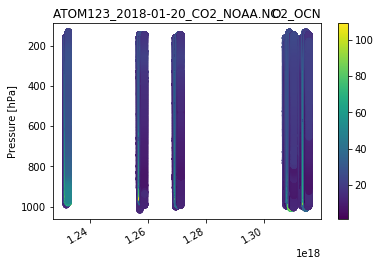

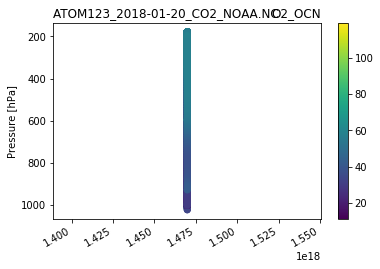

In [20]:
min15 = np.timedelta64(15,'m')
v = 'O2_OCN'
for i,rf in enumerate(rf_model):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    sc = ax.scatter(rf.time.astype(float),
                    rf.Pm.values,c=rf[v].values)

    #ax.set_xlim([data[f].time.values[0]-min15,data[f].time.values[-1]+min15])
    ax.set_ylim(ax.get_ylim()[::-1])
    fig.autofmt_xdate()

    ax.set_ylabel('Pressure [hPa]')
    ax.set_title(f.upper(),loc='left')
    ax.set_title(v,loc='right')
    plt.colorbar(sc)